In [1]:
import uproot 
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, ReLU
from tensorflow.keras.optimizers import SGD
import tensorflow.keras.layers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from xgboost import XGBClassifier

2023-06-06 19:38:54.805105: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-06 19:38:57.319083: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /mu2e/app/users/myucel/mu2e-dev/build/sl7-prof-e20-p040/Offline/lib:/cvmfs/mu2e.opensciencegrid.org/artexternals/cryptopp/v08_02_00/Linux64bit+3.10-2.17-e20-prof:/cvmfs/mu2e.opensciencegrid.org/artexternals/gcc/v9_3_0/Linux64bit+3.10-2.17/lib64:/cvmfs/mu2e.opensciencegrid.org/artexternals/gcc/v9_3_0/Linux64bit+3.10-2.17/lib:/cvmfs/fermilab.opensciencegrid.org/products/common/db/../prd/curl/v7_6

In [33]:
input_dataset = np.empty
temp = np.empty
signal = np.empty
backgnd = np.empty
#filelist = os.environ['KKTrainBkgFiles']
filelist = "KKTrainBkgFiles.txt"
print("Using files in " + filelist)
files = open(filelist, 'r')
for filename in files:
    print("Processing: " + filename)    
    with uproot.open(filename) as file:
        bkgdiag = file["BD"]["bkgcdiag"].arrays()
        bkgdiag = bkgdiag[(bkgdiag['nactive']>=3)&(bkgdiag['np']>=2) & ( (bkgdiag['prel']==0) | ( (bkgdiag['prel']<0) & (bkgdiag['mpdg']==11) ) ) ]
        clusterrho = bkgdiag['crho'].to_numpy()
        zmin = bkgdiag['zmin'].to_numpy()
        zmax = bkgdiag['zmax'].to_numpy()
        zgap = bkgdiag['zgap'].to_numpy()
        nplanes = bkgdiag['np'].to_numpy()
        planefraction = bkgdiag['pfrac'].to_numpy()
        nhits = bkgdiag['nactive'].to_numpy()
        prel = bkgdiag['prel'].to_numpy()
        rmscposx = bkgdiag['rmscposx'].to_numpy()
        rmscposy = bkgdiag['rmscposy'].to_numpy()
        rmsctime = bkgdiag['rmsctime'].to_numpy()
        avecedep = bkgdiag['avecedep'].to_numpy()
        print("Processed file " + filename + " with %s hits"%nhits.shape[0])
        temp = np.vstack((clusterrho, zmin, zmax, zgap, nplanes, planefraction, nhits,rmscposx,rmscposy,rmsctime,avecedep)).T
        if input_dataset is np.empty:
            input_dataset = temp
        else:
            input_dataset = np.concatenate((input_dataset, temp))
        sig = prel!=0
        bkg = prel==0
        if signal is np.empty:
            signal = sig
            backgnd = bkg
        else:
            signal = np.concatenate((signal,sig))
            backgnd = np.concatenate((backgnd,bkg))
nclusters=len(input_dataset)
nsignal=signal.sum()
print(len(signal))
nbackgnd=backgnd.sum()
print("Total dataset %s hits, %s signal and %s background"%(nhits,nsignal,nbackgnd))

Using files in KKTrainBkgFiles.txt
Processing: /pnfs/mu2e/scratch/users/myucel/BkgDiag10kPass1.root
Processed file /pnfs/mu2e/scratch/users/myucel/BkgDiag10kPass1.root with 455763 hits
455763
Total dataset [ 4 14  6 ...  6  9  7] hits, 401856 signal and 53907 background


In [34]:
min_len = min(len(input_dataset[signal]), len(input_dataset[backgnd]))
bsize=32
# I need to double the batch_size when truncating as we divide the sample in half later for training
tsize=2*bsize
min_len = min_len - min_len%tsize
print("Training on %s matched hits"%min_len)
signal_dataset = input_dataset[signal][:min_len]
bkg_dataset = input_dataset[backgnd][:min_len]

balanced_input = np.concatenate((signal_dataset, bkg_dataset))
y_balanced_input = np.concatenate((np.ones(signal_dataset.shape[0]), np.zeros(bkg_dataset.shape[0])))
print(len(balanced_input))
print(y_balanced_input.shape[0])
n_variables = balanced_input.shape[1]

x_ce_train, x_ce_test, y_ce_train, y_ce_test = train_test_split(balanced_input, y_balanced_input, test_size=0.5, random_state=42)
x_ce_test, x_ce_valid, y_ce_test, y_ce_valid = train_test_split(x_ce_test, y_ce_test, test_size=0.5, random_state=42)

Training on 53888 matched hits
107776
107776


Zero kerasQuality 0
Non-zero kerasQuality 455763


<function matplotlib.pyplot.show(close=None, block=None)>

/mu2e/app/users/myucel/mu2e-dev/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


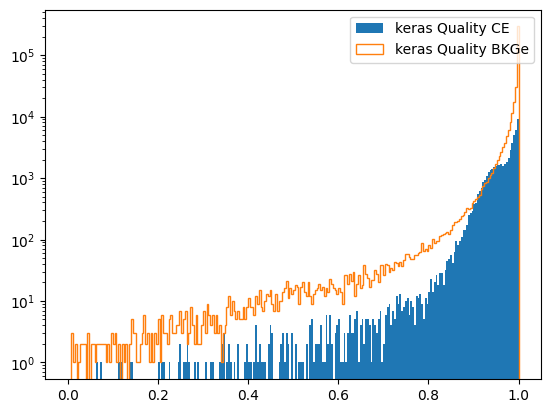

In [35]:
kQCE = kQ[ (prel==0)]
kQbkge = kQ[ (prel!=0)]
kQzero = kQ[kQ==0]
print("Zero kerasQuality",len(kQzero))
print("Non-zero kerasQuality",len(kQ))
plt.hist(kQCE,label="keras Quality CE", log=1, bins=250,range=(0,1))
plt.hist(kQbkge,label="keras Quality BKGe",histtype='step', log=1, bins=250,range=(0,1))
plt.legend()
plt.show

In [36]:
clusterrho_sig = []
zmin_sig = []
zmax_sig = []
zgap_sig = []
nplanes_sig = []
planefraction_sig = []
nhits_sig = []
rmscposx_sig = []
rmscposy_sig = []
rmsctime_sig = []
avecedep_sig = []
        
for i in range(signal_dataset.shape[0]):
    clusterrho_sig.append(signal_dataset[i][0])
    
for i in range(signal_dataset.shape[0]):
    zmin_sig.append(signal_dataset[i][1])
    
for i in range(signal_dataset.shape[0]):
    zmax_sig.append(signal_dataset[i][2])

for i in range(signal_dataset.shape[0]):
    zgap_sig.append(signal_dataset[i][3])
    
for i in range(signal_dataset.shape[0]):
    nplanes_sig.append(signal_dataset[i][4])

for i in range(signal_dataset.shape[0]):
    planefraction_sig.append(signal_dataset[i][5])

for i in range(signal_dataset.shape[0]):
    nhits_sig.append(signal_dataset[i][6])
    
for i in range(signal_dataset.shape[0]):
    rmscposx_sig.append(signal_dataset[i][7])
    
for i in range(signal_dataset.shape[0]):
    rmscposy_sig.append(signal_dataset[i][8])
    
for i in range(signal_dataset.shape[0]):
    rmsctime_sig.append(signal_dataset[i][9])
    
for i in range(signal_dataset.shape[0]):
    avecedep_sig.append(signal_dataset[i][10])
print(min(rmscposx_sig),max(rmscposx_sig))
print(min(rmscposy_sig),max(rmscposy_sig))
print(min(rmsctime_sig),max(rmsctime_sig))
print(min(avecedep_sig),max(avecedep_sig))

6.103515625e-05 74.49412536621094
3.0517578125e-05 75.83491516113281
4.181211948394775 42.057594299316406
0.00019563734531402588 0.005796931218355894


In [37]:
clusterrho_back = []
zmin_back = []
zmax_back = []
zgap_back = []
nplanes_back = []
planefraction_back = []
nhits_back = []
rmscposx_back = []
rmscposy_back = []
rmsctime_back = []
avecedep_back = []

for i in range(bkg_dataset.shape[0]):
    clusterrho_back.append(bkg_dataset[i][0])
    
for i in range(bkg_dataset.shape[0]):
    zmin_back.append(bkg_dataset[i][1])
    
for i in range(bkg_dataset.shape[0]):
    zmax_back.append(bkg_dataset[i][2])

for i in range(bkg_dataset.shape[0]):
    zgap_back.append(bkg_dataset[i][3])

for i in range(bkg_dataset.shape[0]):
    nplanes_back.append(bkg_dataset[i][4])
    
for i in range(bkg_dataset.shape[0]):
    planefraction_back.append(bkg_dataset[i][5])
    
for i in range(bkg_dataset.shape[0]):
    nhits_back.append(bkg_dataset[i][6])
        
for i in range(bkg_dataset.shape[0]):
    rmscposx_back.append(bkg_dataset[i][7])
    
for i in range(bkg_dataset.shape[0]):
    rmscposy_back.append(bkg_dataset[i][8])
    
for i in range(bkg_dataset.shape[0]):
    rmsctime_back.append(bkg_dataset[i][9])
    
for i in range(bkg_dataset.shape[0]):
    avecedep_back.append(bkg_dataset[i][10])
print(min(rmscposx_back),max(rmscposx_back))
print(min(rmscposy_back),max(rmscposy_back))
print(min(rmsctime_back),max(rmsctime_back))
print(min(avecedep_back),max(avecedep_back))

0.004075910896062851 85.73359680175781
0.007864588871598244 85.902099609375
6.452975749969482 43.23966598510742
0.00021135910355951637 0.005624800454825163


<function matplotlib.pyplot.show(close=None, block=None)>

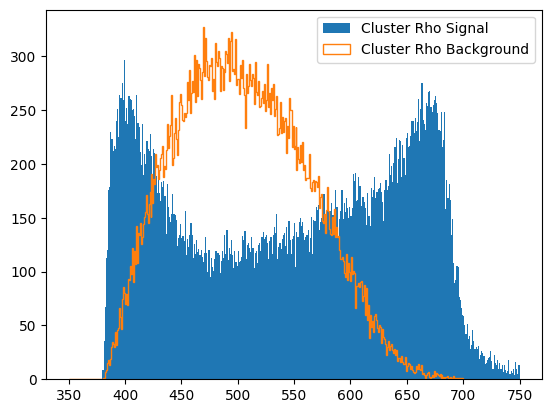

In [38]:
plt.hist(clusterrho_sig,label="Cluster Rho Signal", bins=400,range=(350,750))
plt.hist(clusterrho_back,label="Cluster Rho Background", histtype='step', bins=400,range=(350,700))
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

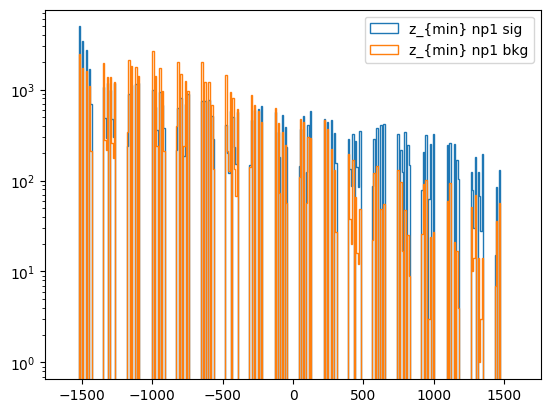

In [15]:
zmin_signp = np.array(zmin_sig)
nplanes_signp = np.array(nplanes_sig)
zmin_backnp = np.array(zmin_back)
nplanes_backnp = np.array(nplanes_back)
zminNp1sig = zmin_signp[ (nplanes_backnp >= 2) ]
zminNp1back = zmin_backnp[ (nplanes_backnp >= 2 ) ]
#plt.hist(zmin_sig,label="z_{min} Signal",log=1, bins=320,range=(-1600.0,1600.0))
#plt.hist(zmin_back,label="z_{min} Background", histtype='step', bins=320, range=(-1600.0,1600.0))
plt.hist(zminNp1sig,label="z_{min} np1 sig", histtype='step', bins=320, range=(-1600.0,1600.0))
plt.hist(zminNp1back,label="z_{min} np1 bkg",log=1, histtype='step', bins=320, range=(-1600.0,1600.0))
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

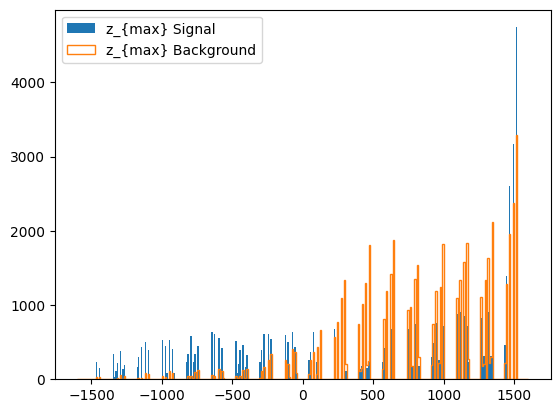

In [16]:
zmax_signp = np.array(zmax_sig)
zmax_backnp = np.array(zmax_back)
zmaxNp1sig = zmax_signp[ (nplanes_backnp >= 1) ]
zmaxNp1back = zmax_backnp[ (nplanes_backnp >= 1 ) ]
plt.hist(zmaxNp1sig,label="z_{max} Signal", bins=320,range=(-1600.0,1600.0))
plt.hist(zmaxNp1back,label="z_{max} Background", histtype='step', bins=320, range=(-1600.0,1600.0))
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

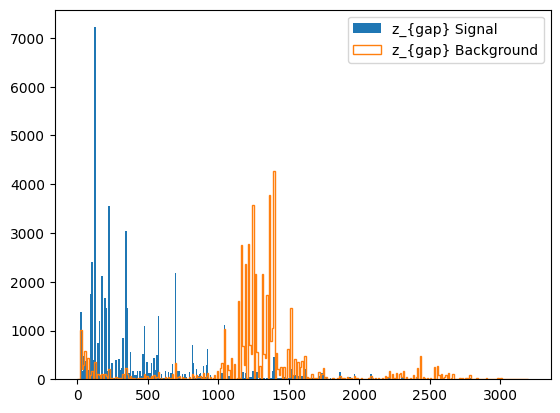

In [17]:
plt.hist(zgap_sig,label="z_{gap} Signal", bins=320,range=(0.0,3200.0))
plt.hist(zgap_back,label="z_{gap} Background", histtype='step', bins=320, range=(0.0,3200.0))
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

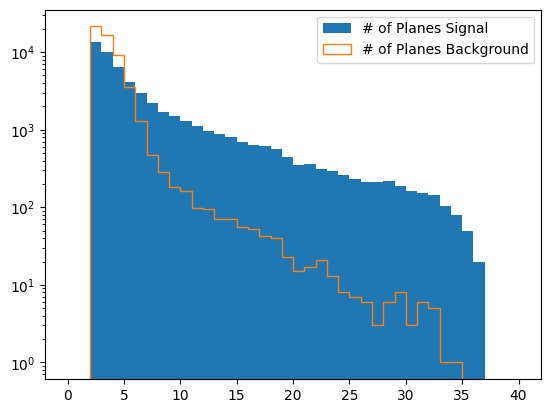

In [18]:
plt.hist(nplanes_sig,label="# of Planes Signal", log=1,bins=40,range=(0,40.0))
plt.hist(nplanes_back,label="# of Planes Background", log=1, histtype='step', bins=40, range=(0,40.0))
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

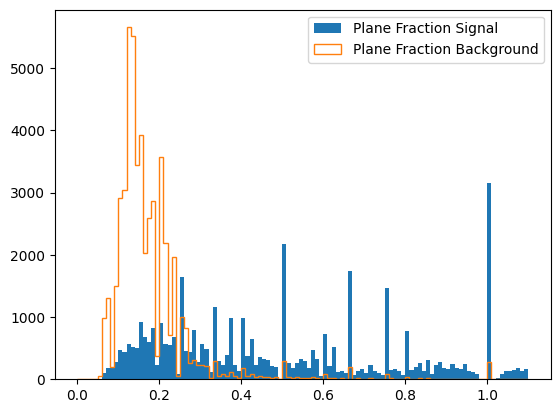

In [19]:
plt.hist(planefraction_sig,label="Plane Fraction Signal", bins=110, range=(0,1.1))
plt.hist(planefraction_back,label="Plane Fraction Background", histtype='step', bins=110, range=(0,1.1))
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

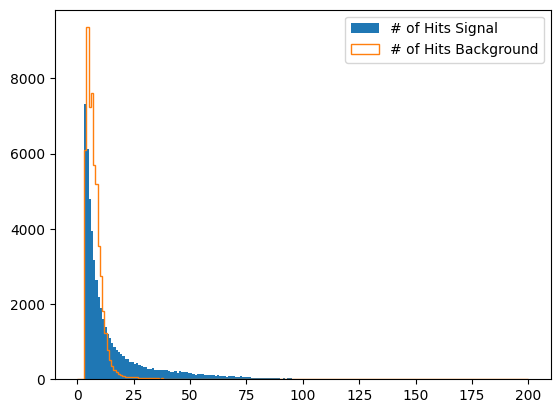

In [20]:
plt.hist(nhits_sig,label="# of Hits Signal", bins=200, range=(0.0,200.0))
plt.hist(nhits_back,label="# of Hits Background", histtype='step', bins=200, range=(0.0,200.0))
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

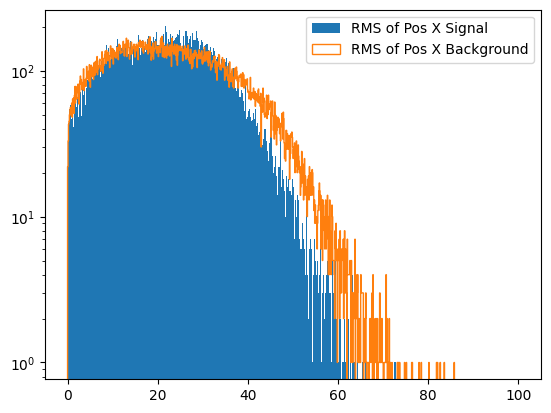

In [21]:
plt.hist(rmscposx_sig,label="RMS of Pos X Signal", log=1,bins=1000, range=(0.,100.0))
plt.hist(rmscposx_back,label="RMS of Pos X Background",log=1, histtype='step', bins=1000, range=(0.,100.0))
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

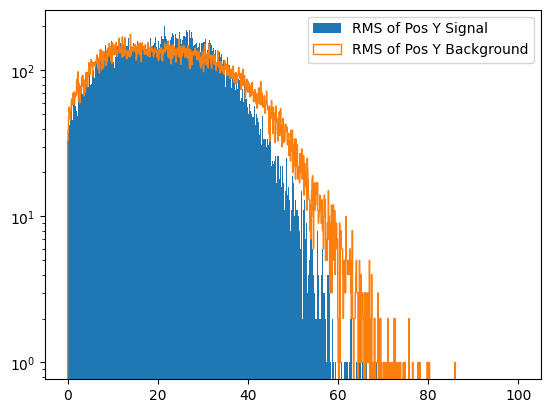

In [22]:
plt.hist(rmscposy_sig,label="RMS of Pos Y Signal",  log=1,bins=1000, range=(0.,100.0))
plt.hist(rmscposy_back,label="RMS of Pos Y Background", log=1, histtype='step', bins=1000, range=(0.,100.0))
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

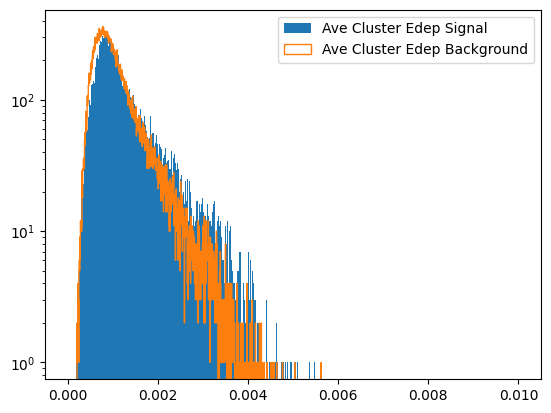

In [23]:
plt.hist(avecedep_sig,label="Ave Cluster Edep Signal",log=1, bins=2000, range=(0.0,0.0100))
plt.hist(avecedep_back,label="Ave Cluster Edep Background",log=1, histtype='step', bins=2000, range=(0.0,0.0100))
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

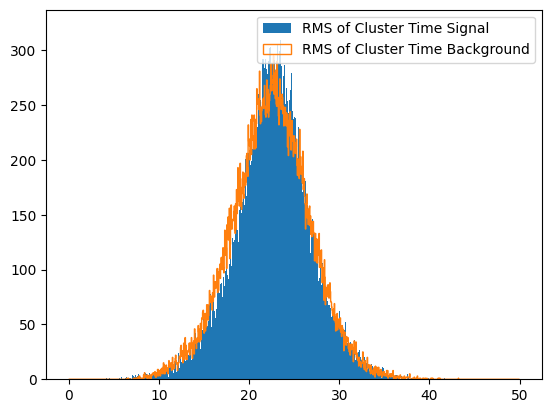

In [39]:
plt.hist(rmsctime_sig,label="RMS of Cluster Time Signal", bins=1000, range=(0.0,50.0))
plt.hist(rmsctime_back,label="RMS of Cluster Time Background",histtype='step', bins=1000, range=(0.0,50.0))
plt.legend()
plt.show

In [40]:
lay0=Input(shape=(n_variables,),batch_size=1)
lay1=Dense(2*n_variables, activation='relu')(lay0)
lay2=Dense(2*n_variables, activation='relu')(lay1)
lay3=Dense(2*n_variables, activation='relu')(lay2)
lay4=Dense(1,activation='sigmoid')(lay3)
output_model=Model(inputs=lay0,outputs=lay4)

opt = Adam(learning_rate=1e-3)
input=Input(shape=(n_variables,),batch_size=bsize)
x=Dense(2*n_variables, activation='relu')(input)
x=Dense(2*n_variables, activation='relu')(x)
x=Dense(2*n_variables, activation='relu')(x)
output=Dense(1,activation='sigmoid')(x)
model_ce=Model(inputs=input,outputs=output)
model_ce.compile(loss='binary_crossentropy',metrics='accuracy',optimizer=opt)
early_stop = EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-5, restore_best_weights=True)
history_ce = model_ce.fit(x_ce_train, y_ce_train,
                          batch_size=bsize,
                          epochs=200,
                          verbose=1,
                          validation_data=(x_ce_valid, y_ce_valid),
                          callbacks=[early_stop]
                         )

Epoch 1/200
1684/1684 [==============================] - 5s 2ms/step - loss: 1.9958 - accuracy: 0.8158 - val_loss: 0.4592 - val_accuracy: 0.8519
Epoch 2/200
1684/1684 [==============================] - 3s 2ms/step - loss: 0.4685 - accuracy: 0.8435 - val_loss: 0.4104 - val_accuracy: 0.8461
Epoch 3/200
1684/1684 [==============================] - 3s 2ms/step - loss: 0.4122 - accuracy: 0.8536 - val_loss: 0.3932 - val_accuracy: 0.8624
Epoch 4/200
1684/1684 [==============================] - 4s 2ms/step - loss: 0.3688 - accuracy: 0.8595 - val_loss: 0.3657 - val_accuracy: 0.8624
Epoch 5/200
1684/1684 [==============================] - 4s 2ms/step - loss: 0.3502 - accuracy: 0.8643 - val_loss: 0.3486 - val_accuracy: 0.8647
Epoch 6/200
1684/1684 [==============================] - 4s 2ms/step - loss: 0.3465 - accuracy: 0.8663 - val_loss: 0.3710 - val_accuracy: 0.8617
Epoch 7/200
1684/1684 [==============================] - 3s 2ms/step - loss: 0.3389 - accuracy: 0.8675 - val_loss: 0.3643 - val_ac

In [41]:
model_xgboost = XGBClassifier()
model_xgboost.fit(x_ce_train, y_ce_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [42]:
#prediction_ce = model_ce.predict(x_ce_test).ravel()
prediction_ce = model_ce.predict(x_ce_test)
fpr_ce, tpr_ce, th_ce = roc_curve(y_ce_test,  prediction_ce)
auc_ce = roc_auc_score(y_ce_test, prediction_ce)

842/842 [==============================] - 1s 1ms/step


In [43]:
prediction_xgboost = model_xgboost.predict_proba(x_ce_test)[:,1]
fpr_xgboost, tpr_xgboost, th_xgboost = roc_curve(y_ce_test,  prediction_xgboost)
auc_xgboost = roc_auc_score(y_ce_test, prediction_xgboost)

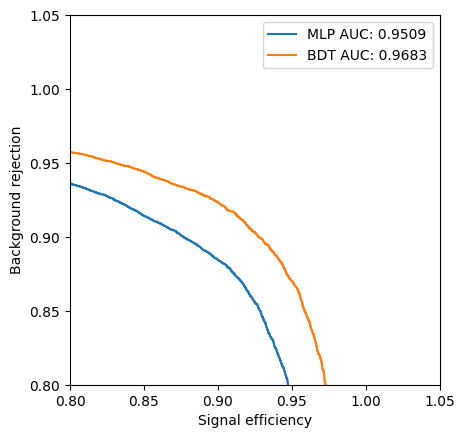

In [44]:
fig, ax = plt.subplots(1,1)
ax.plot(tpr_ce,1-fpr_ce,label=f'MLP AUC: {auc_ce:.4f}')
ax.plot(tpr_xgboost,1-fpr_xgboost,label=f'BDT AUC: {auc_xgboost:.4f}')

ax.legend()
ax.set_aspect("equal")
ax.set_xlabel("Signal efficiency")
ax.set_ylabel("Background rejection")
ax.set_xlim(0.8,1.05)
ax.set_ylim(0.8,1.05)
fig.savefig("TrainBkgDiag.pdf")

In [32]:
output_model.set_weights(model_ce.get_weights())
output_model.summary()
output_model.save("TrainBkgDiag.h5")
#model_ce.save("TrainBkgDiag.h5")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(1, 11)]                 0         
                                                                 
 dense (Dense)               (1, 22)                   264       
                                                                 
 dense_1 (Dense)             (1, 22)                   506       
                                                                 
 dense_2 (Dense)             (1, 22)                   506       
                                                                 
 dense_3 (Dense)             (1, 1)                    23        
                                                                 
Total params: 1,299
Trainable params: 1,299
Non-trainable params: 0
_________________________________________________________________
